# Data Analysis (qubit_TransmonCross_cap_matrix)

## Configuration

Disable cell scrolling.

Parameters are stored in a shared script.

In [1]:
from parameters import *
os.makedirs('scalers', exist_ok=True)
os.makedirs(f'{DATA_DIR}', exist_ok=True)
os.makedirs(f'{DATA_DIR}/npy', exist_ok=True)

## Library

In [2]:
import json
import numpy as np
import pandas as pd
from pandas import json_normalize
from sklearn.preprocessing import MinMaxScaler
import joblib

## Datasets

### Load
From https://huggingface.co/datasets/SQuADDS/SQuADDS_DB/tree/main

In [3]:
df = pd.read_json("qubit-TransmonCross-Hamiltonian_params.json")

### Look at the data and structure

In [4]:
#look at the first value
first_entry = df.iloc[100]

# Print the headers and their corresponding values
for header, value in first_entry.items():
    print(f"{header}: {value}")

sim_results: {'cross_to_ground': 155.21897, 'claw_to_ground': 63.04611, 'cross_to_claw': 1.83606, 'cross_to_cross': 155.21897, 'claw_to_claw': 65.18175, 'ground_to_ground': 279.3005, 'units': 'fF'}
sim_options: {'setup': {'name': 'sweep_setup', 'reuse_selected_design': False, 'reuse_setup': False, 'freq_ghz': 5.0, 'save_fields': False, 'enabled': True, 'max_passes': 30, 'min_passes': 2, 'min_converged_passes': 1, 'percent_error': 0.1, 'percent_refinement': 30, 'auto_increase_solution_order': True, 'solution_order': 'High', 'solver_type': 'Iterative', 'run': {'name': 'sweep_v2.0', 'components': ['Q'], 'open_terminations': [['Q', 'readout']], 'box_plus_buffer': True}}, 'renderer_options': {'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.2, 'y_buffer_width_mm': 0.2, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 5, 'plot_ansys_fields_options': {'nam

In [5]:
#Look at the headers relevant for us, to start lets only look at the sim_results (our x data) and design (our y data)
sim_results_column = df['sim_results']
print(sim_results_column, '\n\n')

# calculated from sim_results capacitance matrices
Hamiltonian_column = df['Hamiltonian_params']
print(Hamiltonian_column, '\n\n')

design_column = df['design']
print(design_column)

0       {'cross_to_ground': 158.40783, 'claw_to_ground...
1       {'cross_to_ground': 188.15089, 'claw_to_ground...
2       {'cross_to_ground': 104.3534, 'claw_to_ground'...
3       {'cross_to_ground': 174.13928, 'claw_to_ground...
4       {'cross_to_ground': 120.03923, 'claw_to_ground...
                              ...                        
1929    {'cross_to_ground': 174.4638, 'claw_to_ground'...
1930    {'cross_to_ground': 187.43537, 'claw_to_ground...
1931    {'cross_to_ground': 172.14561, 'claw_to_ground...
1932    {'cross_to_ground': 56.7523, 'claw_to_ground':...
1933    {'cross_to_ground': 62.01, 'claw_to_ground': 5...
Name: sim_results, Length: 1934, dtype: object 


0       {'qubit_frequency_GHz': 3.8270200473, 'anharmo...
1       {'qubit_frequency_GHz': 3.5344959733, 'anharmo...
2       {'qubit_frequency_GHz': 4.6636779034, 'anharmo...
3       {'qubit_frequency_GHz': 3.6392018632000003, 'a...
4       {'qubit_frequency_GHz': 4.373602634, 'anharmon...
                      

In [6]:
#take a look at everything in the design dataset
# Flatten the design column
design_flat = json_normalize(df['design'])

# List all column headers
design_column_vals = design_flat.columns.tolist()
print(design_column_vals)
print('length: ',len(design_column_vals))

['design_tool', 'design_options.pos_x', 'design_options.pos_y', 'design_options.orientation', 'design_options.chip', 'design_options.layer', 'design_options.connection_pads.readout.connector_type', 'design_options.connection_pads.readout.claw_length', 'design_options.connection_pads.readout.ground_spacing', 'design_options.connection_pads.readout.claw_width', 'design_options.connection_pads.readout.claw_gap', 'design_options.connection_pads.readout.claw_cpw_length', 'design_options.connection_pads.readout.claw_cpw_width', 'design_options.connection_pads.readout.connector_location', 'design_options.cross_width', 'design_options.cross_length', 'design_options.cross_gap', 'design_options.hfss_inductance', 'design_options.hfss_capacitance', 'design_options.hfss_resistance', 'design_options.hfss_mesh_kw_jj', 'design_options.q3d_inductance', 'design_options.q3d_capacitance', 'design_options.q3d_resistance', 'design_options.q3d_mesh_kw_jj', 'design_options.gds_cell_name', 'design_options.aedt

### Reformat

In [7]:
#flatten what will be our X data
X = json_normalize(df['Hamiltonian_params'])
print(X)

      qubit_frequency_GHz  anharmonicity_MHz
0                3.827020        -128.905036
1                3.534496        -108.645178
2                4.663678        -198.384651
3                3.639202        -115.668161
4                4.373603        -172.281911
...                   ...                ...
1929             3.648987        -116.337413
1930             3.496582        -106.164155
1931             3.640279        -115.741704
1932             6.189599        -375.717749
1933             5.944164        -342.190821

[1934 rows x 2 columns]


In [8]:
#flatten what will be our y data
y = json_normalize(df['design'])

In [9]:
columns_to_drop = ['design_tool', 'design_options.pos_x', 'design_options.pos_y',
       'design_options.orientation', 'design_options.chip',
       'design_options.layer',
       'design_options.connection_pads.readout.connector_type',
       'design_options.connection_pads.readout.claw_width',
       'design_options.connection_pads.readout.claw_gap',
       'design_options.connection_pads.readout.claw_cpw_length',
       'design_options.connection_pads.readout.claw_cpw_width',
       'design_options.connection_pads.readout.connector_location',
       'design_options.cross_width',
       'design_options.cross_gap', 'design_options.hfss_inductance',
       'design_options.hfss_capacitance', 'design_options.hfss_resistance',
       'design_options.hfss_mesh_kw_jj', 'design_options.q3d_inductance',
       'design_options.q3d_capacitance', 'design_options.q3d_resistance',
       'design_options.q3d_mesh_kw_jj', 'design_options.gds_cell_name',
       'design_options.aedt_q3d_inductance',
       'design_options.aedt_q3d_capacitance',
       'design_options.aedt_hfss_inductance',
       'design_options.aedt_hfss_capacitance']

In [10]:
#get rid of this column because there are two spellings in the dataset that will confuse the NN. We always just use Qiskit, so for now we dont need this
y = y.drop(columns=columns_to_drop) 

#output of processing later on when I dont drop this column:
'''
One-hot encoding for 'design_tool':
      design_tool_Qiskit Metal  design_tool_qiskit-metal
 0                          0.0                       1.0 
'''

print(y)

     design_options.connection_pads.readout.claw_length  \
0                                                 160um   
1                                                 120um   
2                                                 130um   
3                                                 180um   
4                                                  90um   
...                                                 ...   
1929                                              190um   
1930                                              240um   
1931                                              280um   
1932                                               90um   
1933                                               70um   

     design_options.connection_pads.readout.ground_spacing  \
0                                                  10um      
1                                                 9.1um      
2                                                  10um      
3                                          

### Validate and View Data

In [11]:
display(X)

,qubit_frequency_GHz,anharmonicity_MHz
0,3.827020,-128.905036
1,3.534496,-108.645178
2,4.663678,-198.384651
3,3.639202,-115.668161
4,4.373603,-172.281911
...,...,...
1929,3.648987,-116.337413
1930,3.496582,-106.164155
1931,3.640279,-115.741704
1932,6.189599,-375.717749


In [12]:
display(y)

,design_options.connection_pads.readout.claw_length,design_options.connection_pads.readout.ground_spacing,design_options.cross_length
0,160um,10um,310um
1,120um,9.1um,350um
2,130um,10um,210um
3,180um,5um,330um
4,90um,5um,230um
...,...,...,...
1929,190um,10um,340um
1930,240um,4.1um,370um
1931,280um,9.1um,330um
1932,90um,10um,120um


## Transform Y to Numerical Values

We need to do this because the MLP needs its output to have numerical values, so we will transform the 3 columns into numerical equivalents. 

In [13]:
#look at the format all of the y values are in
for col in y.columns:
    print(f"{col}  {y[col].iloc[0]}")
print(y.shape)

design_options.connection_pads.readout.claw_length  160um
design_options.connection_pads.readout.ground_spacing  10um
design_options.cross_length  310um
(1934, 3)


In [14]:
y_numerical = y.copy()

In [15]:
if 'one hot' in ENCODING_TYPE:
    y_encoding_formats = [y_numerical]
    y_encoding_format_names = ['one_hot']
elif 'Linear' in ENCODING_TYPE:
    y_encoding_format_names = ['linear']
    y_encoding_formats = [y_numerical]
elif 'Try Both' in ENCODING_TYPE:
    y_encoding_format_names = ['one_hot','linear']
    y_encoding_formats = [y_numerical_one_hot, y_numerical_linear]

y_numerical_removed_um_encoding_formats = []
for y_format in y_encoding_formats:
    y_numerical_removed_um = y_format.copy()
    
    # Extract numerical values and convert units (assuming 'um' for all)
    um_cols = [col for col in y_numerical_removed_um.columns if y_numerical_removed_um[col].astype(str).str.contains('um').any()]
    
    for col in um_cols:
        y_numerical_removed_um[col] = pd.to_numeric(y_numerical_removed_um[col].astype(str).str.replace('um', '', regex=False), errors='coerce') * 1e-6
        y_numerical_removed_um[col] = y_numerical_removed_um[col].round(15) #round to get rid of the long .999999999s that python does sometimes
    
    nH_cols = [col for col in y_numerical_removed_um.columns if y_numerical_removed_um[col].astype(str).str.contains('nH').any()]
    for col in nH_cols:
        y_numerical_removed_um[col] = pd.to_numeric(y_numerical_removed_um[col].astype(str).str.replace('nH', '', regex=False), errors='coerce') * 1e-9
        y_numerical_removed_um[col] = y_numerical_removed_um[col].round(15) #round to get rid of the long .999999999s that python does sometimes
    
    y_numerical_removed_um_encoding_formats.append(y_numerical_removed_um)
    i =0
    for col in y_numerical_removed_um.columns:
        i+=1
        try:
            print(f"{col}-----------Numerical Version:{y_numerical_removed_um[col].iloc[0]}-----------Original:{y[col].iloc[0]}")
        except KeyError:
            print("hot encoding changed this column name from the original")
    print('\n')

design_options.connection_pads.readout.claw_length-----------Numerical Version:0.00016-----------Original:160um
design_options.connection_pads.readout.ground_spacing-----------Numerical Version:1e-05-----------Original:10um
design_options.cross_length-----------Numerical Version:0.00031-----------Original:310um




In [16]:
#print how many columns have nan in them
for col in y.columns:
    total = len(y[col])

    # NaN stats
    n_nan = y[col].isna().sum()
    
    # Only report columns with some, but not all, NaNs
    if 0 < n_nan < total:
        pct_nan = n_nan / total * 100

        # "0.0" stats (treat values as strings and look for substring "0.0")
        zero_mask = y[col].astype(str).str.contains("0.0", na=False)
        n_zero = zero_mask.sum()
        pct_zero = n_zero / total * 100

        print(f"{col}:")
        print(f"  NaN values:  {n_nan}/{total}  ({pct_nan:.2f}%)")
        print(f"  '0.0' vals:  {n_zero}/{total}  ({pct_zero:.2f}%)")
        print()

In [17]:
y_numerical_flagged_nan_encoding_formats = []
for y_encoding_formats_um_removed in y_numerical_removed_um_encoding_formats:
    y_numerical_flagged_nan = y_encoding_formats_um_removed.copy()
    y_numerical_flagged_nan.fillna(float(1), inplace=True)
    
    y_numerical_flagged_nan_encoding_formats.append(y_numerical_flagged_nan) #save updated dictionaries to a new list
    
    print('\n')
    print('Now all of these should be numerical')
    for col in y_numerical_flagged_nan.columns:
        print(f"{col}-----------{y_numerical_flagged_nan[col].iloc[0]}")
        #print(f"{col}-----------Numerical Version:{y_numerical_flagged_nan[col].iloc[0]}-----------Original:{y[col].iloc[0]}")



Now all of these should be numerical
design_options.connection_pads.readout.claw_length-----------0.00016
design_options.connection_pads.readout.ground_spacing-----------1e-05
design_options.cross_length-----------0.00031


In [18]:
y_numerical_floats_encoding_formats = []
for y_numerical_flagged_nan_format in y_numerical_flagged_nan_encoding_formats:
    
    y_numerical_ = y_numerical_flagged_nan_format.copy()
    y_numerical_floats_encoding_formats.append(y_numerical_)

In [19]:
y_encoding_formats = []
for y_transformed in y_numerical_floats_encoding_formats:
    y_encoding_formats.append(y_transformed)

i=0
for y_encoding_format in y_encoding_formats:
    print('Encoding Type: ',y_encoding_format_names[i])
    display(y_encoding_format)
    i+=1

Encoding Type:  one_hot


,design_options.connection_pads.readout.claw_length,design_options.connection_pads.readout.ground_spacing,design_options.cross_length
0,0.00016,0.000010,0.00031
1,0.00012,0.000009,0.00035
2,0.00013,0.000010,0.00021
3,0.00018,0.000005,0.00033
4,0.00009,0.000005,0.00023
...,...,...,...
1929,0.00019,0.000010,0.00034
1930,0.00024,0.000004,0.00037
1931,0.00028,0.000009,0.00033
1932,0.00009,0.000010,0.00012


### Save the header names of the y data

In [20]:
i=0
for y_encoding_format in y_encoding_formats:
    filename = f'y_characteristics_{y_encoding_format_names[i]}_encoding.csv'
    headers = list(y_encoding_format.columns) 
    
    with open(filename, 'w') as f:
        f.write(','.join(headers))
    i+=1

## Visualize

### X Data

In [21]:
%matplotlib ipympl
#%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math

In [22]:
num_cols = len(X.columns)
num_rows = math.ceil(num_cols / 3)  # Adjust 3 for the desired number of columns in subplot

fig, axes = plt.subplots(num_rows, 3, figsize=(10, 3 * num_rows)) # Adjust figsize as needed

axes = axes.ravel() # Flatten the axes array for easier iteration

for i, column_header in enumerate(X.columns):
    axes[i].hist(X[column_header], bins=30, edgecolor='black')
    axes[i].set_title(f'Histogram of {column_header}')
    axes[i].set_xlabel(f'{column_header}')
    axes[i].set_ylabel('Frequency')


# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('plots/unscaled_X_data.png')
plt.close()

### Y data

In [23]:
i=0
for y_encoding_format in y_encoding_formats:
    num_cols = len(y_encoding_format.columns)
    num_rows = ((num_cols + 2) // 4) + 1
    
    plt.figure(figsize=(14, 2 * num_rows)) #Reduced figure size
    
    for n, col in enumerate(y_encoding_format.columns):
        try:
            plt.subplot(num_rows, 4, n + 1)
            plt.hist(y_encoding_format[col], bins=30, edgecolor='black')
            plt.xlabel(col.split('design_options.')[-1], fontsize=8) 
            plt.ylabel('Frequency', fontsize=8) 
            plt.tick_params(axis='both', which='major', labelsize=7) 
    
        except TypeError:
            print(f"Warning: Column '{col}' is not numeric and cannot be plotted.")
    
    plt.tight_layout()
    plt.savefig(f'plots/unscaled_y_data_{y_encoding_format_names[i]}_encoding.png')
    #plt.show()
    i+=1

In [24]:
plt.close()

## Augment 

### Scale X

Scale kappa and frequency to be between 0 and 1

In [25]:
X_scaled = X.copy()
for col in X_scaled.columns:
    scaler = MinMaxScaler()
    X_scaled[col] = scaler.fit_transform(X_scaled[[col]]) #only fit to this column
    joblib.dump(scaler, f'scalers/scaler_X_{col}.save') #save for later

In [26]:
# Check the scaling
display(X_scaled)

,qubit_frequency_GHz,anharmonicity_MHz
0,0.155701,0.908558
1,0.080849,0.954934
2,0.369786,0.749515
3,0.107642,0.938858
4,0.295561,0.809266
...,...,...
1929,0.110145,0.937326
1930,0.071148,0.960613
1931,0.107917,0.938690
1932,0.760242,0.343589


### Scale y

In [27]:
y_scaled_encoding_formats = []

i=0
for y_encoding_format in y_encoding_formats:
    y_scaled = y_encoding_format.copy()
    for col in y_scaled.columns:
        scaler = MinMaxScaler()
        y_scaled[col] = scaler.fit_transform(y_scaled[[col]]) #only fit to this column
        joblib.dump(scaler, f'scalers/scaler_y_{col}_{y_encoding_format_names[i]}_encoding.save') #save for later
    y_scaled_encoding_formats.append(y_scaled)
    i+=1

### Plot Scaled Data

### X

In [28]:
num_cols = len(X.columns)
num_rows = math.ceil(num_cols / 3)  # Adjust 3 for the desired number of columns in subplot

fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows)) # Adjust figsize as needed

axes = axes.ravel() # Flatten the axes array for easier iteration

for i, column_header in enumerate(X.columns):
    axes[i].hist(X[column_header], bins=30, edgecolor='black')
    axes[i].set_title(f'Histogram of {column_header}')
    axes[i].set_xlabel(f'{column_header}')
    axes[i].set_ylabel('Frequency')


# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('plots/scaled_X_data.png')
plt.close()

### Y

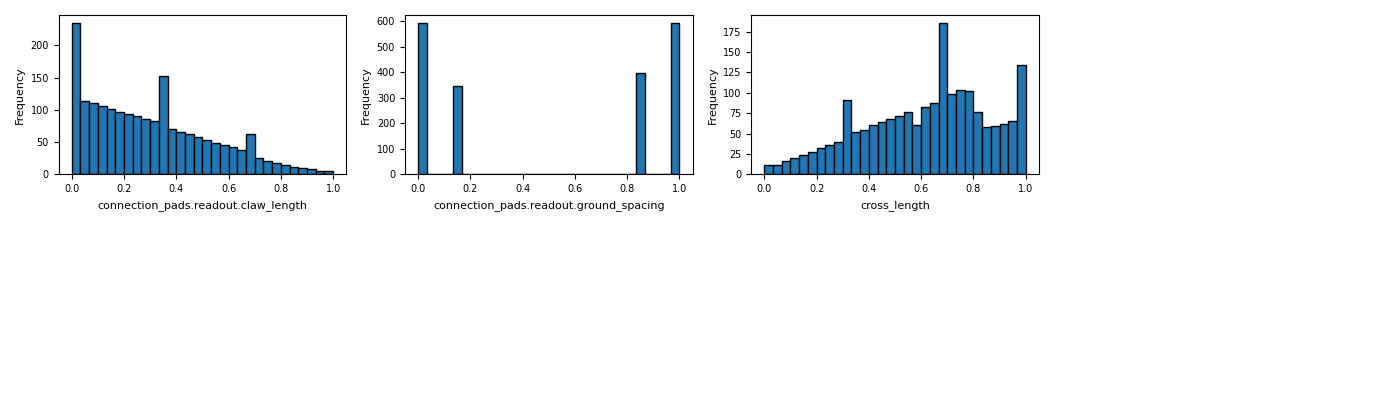

In [29]:
i=0
for y_scaled in y_scaled_encoding_formats:

    num_cols = len(y_scaled.columns)
    num_rows = ((num_cols + 2) // 4) + 1
    
    plt.figure(figsize=(14, 2 * num_rows)) #Reduced figure size
    
    for n, col in enumerate(y_scaled.columns):
        try:
            plt.subplot(num_rows, 4, n + 1)
            plt.hist(y_scaled[col], bins=30, edgecolor='black')
            plt.xlabel(col.split('design_options.')[-1], fontsize=8) 
            plt.ylabel('Frequency', fontsize=8) 
            plt.tick_params(axis='both', which='major', labelsize=7) 
    
        except TypeError:
            print(f"Warning: Column '{col}' is not numeric and cannot be plotted.")
    
    plt.tight_layout()
    plt.savefig(f'plots/scaled_y_data_{y_encoding_format_names[i]}_encoding.png')
    plt.show()
    i+=1

In [30]:
plt.close()

### Unscale to make sure you can recreate original values with saved scaler

### 
Unscale X

In [31]:
X_orig = X_scaled.copy()
for col in X_scaled.columns:
    scaler = joblib.load(f'scalers/scaler_X_{col}.save')
    X_orig[col] = scaler.inverse_transform(X_scaled[[col]]) 

display(X_orig)

,qubit_frequency_GHz,anharmonicity_MHz
0,3.827020,-128.905036
1,3.534496,-108.645178
2,4.663678,-198.384651
3,3.639202,-115.668161
4,4.373603,-172.281911
...,...,...
1929,3.648987,-116.337413
1930,3.496582,-106.164155
1931,3.640279,-115.741704
1932,6.189599,-375.717749


In [32]:
num_cols = len(X.columns)
num_rows = math.ceil(num_cols / 3)  # Adjust 3 for the desired number of columns in subplot

fig, axes = plt.subplots(num_rows, 3, figsize=(10, 3 * num_rows)) # Adjust figsize as needed

axes = axes.ravel() # Flatten the axes array for easier iteration

for i, column_header in enumerate(X_orig.columns):
    axes[i].hist(X_orig[column_header], bins=30, edgecolor='black')
    axes[i].set_title(f'Histogram of {column_header}')
    axes[i].set_xlabel(f'{column_header}')
    axes[i].set_ylabel('Frequency')


# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()

### Unscale Y

In [33]:
y_orig_encoding_formats = []

i=0
for y_scaled in y_scaled_encoding_formats:
    y_orig = y_scaled.copy()
    for col in y_scaled.columns:
        scaler = joblib.load(f'scalers/scaler_y_{col}_{y_encoding_format_names[i]}_encoding.save')
        y_orig[col] = scaler.inverse_transform(y_scaled[[col]])
    y_orig_encoding_formats.append(y_orig)
    print('Encoding Type: ', y_encoding_format_names[i])
    display(y_orig)
    print('\n')
    i+=1

Encoding Type:  one_hot


,design_options.connection_pads.readout.claw_length,design_options.connection_pads.readout.ground_spacing,design_options.cross_length
0,0.00016,0.000010,0.00031
1,0.00012,0.000009,0.00035
2,0.00013,0.000010,0.00021
3,0.00018,0.000005,0.00033
4,0.00009,0.000005,0.00023
...,...,...,...
1929,0.00019,0.000010,0.00034
1930,0.00024,0.000004,0.00037
1931,0.00028,0.000009,0.00033
1932,0.00009,0.000010,0.00012


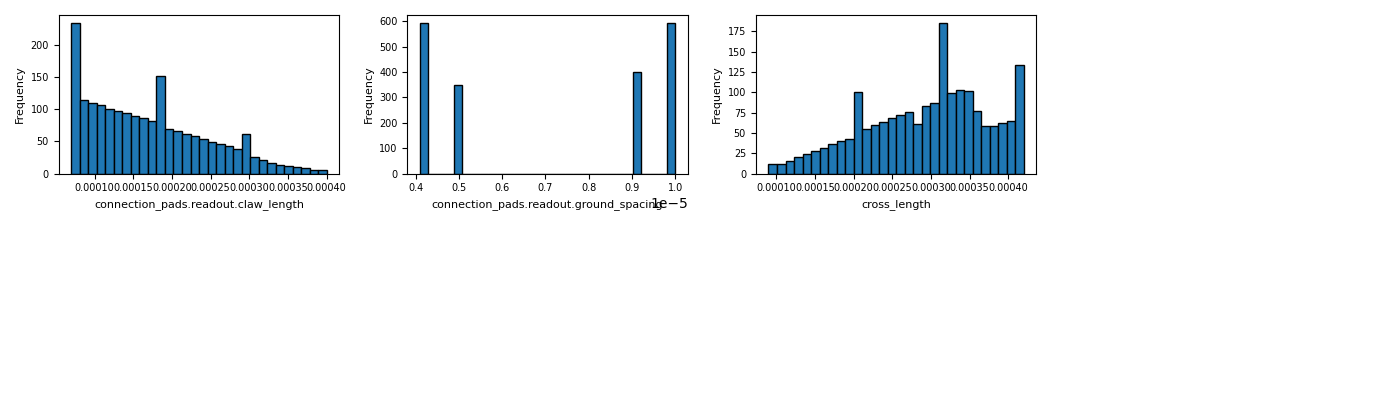

In [34]:
i=0
for y_orig in y_orig_encoding_formats:
    num_cols = len(y_orig.columns)
    num_rows = ((num_cols + 2) // 4) + 1
    
    plt.figure(figsize=(14, 2 * num_rows)) #Reduced figure size
    
    for i, col in enumerate(y_orig.columns):
        try:
            plt.subplot(num_rows, 4, i + 1)
            plt.hist(y_orig[col], bins=30, edgecolor='black')
            plt.xlabel(col.split('design_options.')[-1], fontsize=8) 
            plt.ylabel('Frequency', fontsize=8) 
            plt.tick_params(axis='both', which='major', labelsize=7) 
    
        except TypeError:
            print(f"Warning: Column '{col}' is not numeric and cannot be plotted.")
    
    plt.tight_layout()
    plt.show()
    i+=1

## Split

In [35]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
print('Tensorflow ver.', tf.__version__)

Tensorflow ver. 2.16.2


Dataset split is 80%-20% training-validation and test sets. We use a constant state (seed) for reproducible splits across multiple runs.

In [36]:
# Unscaled data split
if 'one hot' in ENCODING_TYPE:
    X_train, X_val_test, y_train_one_hot_encoding, y_val_test_one_hot_encoding = train_test_split(
        X, y_encoding_formats[0], test_size=0.3, random_state=42, shuffle=True
    ) # 70% train, 30% val/test
    X_val, X_test, y_val_one_hot_encoding, y_test_one_hot_encoding = train_test_split(
        X_val_test, y_val_test_one_hot_encoding, test_size=0.5, random_state=42, shuffle=True
    ) # Split the 30% into 15% val, 15% test

elif 'Linear' in ENCODING_TYPE:
    X_train, X_val_test, y_train_linear_encoding, y_val_test_linear_encoding = train_test_split(
        X, y_encoding_formats[1], test_size=0.3, random_state=42, shuffle=True
    )
    X_val, X_test, y_val_linear_encoding, y_test_linear_encoding = train_test_split(
        X_val_test, y_val_test_linear_encoding, test_size=0.5, random_state=42, shuffle=True
    )
elif 'Try Both' in ENCODING_TYPE:
    X_train_one_hot_encoding, X_val_test_one_hot_encoding, y_train_one_hot_encoding, y_val_test_one_hot_encoding = train_test_split(
        X, y_encoding_formats[0], test_size=0.3, random_state=42, shuffle=True
    )
    X_val_one_hot_encoding, X_test_one_hot_encoding, y_val_one_hot_encoding, y_test_one_hot_encoding = train_test_split(
        X_val_test_one_hot_encoding, y_val_test_one_hot_encoding, test_size=0.5, random_state=42, shuffle=True
    )
    X_train_linear_encoding, X_val_test_linear_encoding, y_train_linear_encoding, y_val_test_linear_encoding = train_test_split(
        X, y_encoding_formats[1], test_size=0.3, random_state=42, shuffle=True
    )
    X_val_linear_encoding, X_test_linear_encoding, y_val_linear_encoding, y_test_linear_encoding = train_test_split(
        X_val_test_linear_encoding, y_val_test_linear_encoding, test_size=0.5, random_state=42, shuffle=True
    )

# Scaled data split
if 'one hot' in ENCODING_TYPE:
    X_train_scaled, X_val_test_scaled, y_train_scaled_one_hot_encoding, y_val_test_scaled_one_hot_encoding = train_test_split(
        X_scaled, y_scaled_encoding_formats[0], test_size=0.3, random_state=42, shuffle=True
    ) # 70% train, 30% val/test
    X_val_scaled, X_test_scaled, y_val_scaled_one_hot_encoding, y_test_scaled_one_hot_encoding = train_test_split(
        X_val_test_scaled, y_val_test_scaled_one_hot_encoding, test_size=0.5, random_state=42, shuffle=True
    ) # Split the 30% into 15% val, 15% test

elif 'Linear' in ENCODING_TYPE:
    X_train_scaled, X_val_test_scaled, y_train_linear_hot_encoding, y_val_test_linear_hot_encoding = train_test_split(
        X_scaled, y_scaled_encoding_formats[0], test_size=0.3, random_state=42, shuffle=True
    ) # 70% train, 30% val/test
    X_val_scaled, X_test_scaled, y_val_scaled_linear_encoding, y_test_scaled_linear_encoding = train_test_split(
        X_val_test_scaled, y_val_test_scaled_linear_encoding, test_size=0.5, random_state=42, shuffle=True
    ) # Split the 30% into 15% val, 15% test
elif 'Try Both' in ENCODING_TYPE:
    X_train_scaled_one_hot_encoding, X_val_test_scaled_one_hot_encoding, y_train_scaled_one_hot_encoding, y_val_test_scaled_one_hot_encoding = train_test_split(
        X_scaled, y_scaled_encoding_formats[0], test_size=0.3, random_state=42, shuffle=True
    ) # 70% train, 30% val/test
    X_val_scaled_one_hot_encoding, X_test_scaled_one_hot_encoding, y_val_scaled_one_hot_encoding, y_test_scaled_one_hot_encoding = train_test_split(
        X_val_test_scaled_one_hot_encoding, y_val_test_scaled_one_hot_encoding, test_size=0.5, random_state=42, shuffle=True
    ) # Split the 30% into 15% val, 15% test

    X_train_scaled_linear_encoding, X_val_test_scaled_linear_encoding, y_train_scaled_linear_encoding, y_val_test_scaled_linear_encoding = train_test_split(
        X_scaled, y_scaled_encoding_formats[0], test_size=0.3, random_state=42, shuffle=True
    ) # 70% train, 30% val/test
    X_val_scaled_linear_encoding, X_test_scaled_linear_encoding, y_val_scaled_linear_encoding, y_test_scaled_linear_encoding = train_test_split(
        X_val_test_scaled_linear_encoding, y_val_test_scaled_linear_encoding, test_size=0.5, random_state=42, shuffle=True
    ) # Split the 30% into 15% val, 15% test


In [37]:
#unscaled
if 'one hot' in ENCODING_TYPE:
    total = y_train_one_hot_encoding.shape[0] + y_test_one_hot_encoding.shape[0] + y_val_one_hot_encoding.shape[0]
    print('---------------------------------------')
    print('Train one-hot encoding set shape: {}, {:.2f}%'.format(y_train_one_hot_encoding.shape, (y_train_one_hot_encoding.shape[0]*100.)/total))
    print('Validation one-hot encoding set shape: {}, {:.2f}%'.format(y_val_one_hot_encoding.shape, (y_val_one_hot_encoding.shape[0]*100.)/total))
    print('Test set shape:                 {}, {:.2f}%'.format(y_test_one_hot_encoding.shape, (y_test_one_hot_encoding.shape[0]*100.)/total))
    print('---------------------------------------')
elif 'Linear' in ENCODING_TYPE:
    total = y_train_linear_encoding.shape[0] + y_test_linear_encoding.shape[0] + y_val_linear_encoding.shape[0]
    print('---------------------------------------')
    print('Train linear encoding set shape: {}, {:.2f}%'.format(y_train_linear_encoding.shape, (y_train_linear_encoding.shape[0]*100.)/total))
    print('Validation linear encoding set shape: {}, {:.2f}%'.format(y_val_linear_encoding.shape, (y_val_linear_encoding.shape[0]*100.)/total))
    print('Test set shape:                 {}, {:.2f}%'.format(y_test_linear_encoding.shape, (y_test_linear_encoding.shape[0]*100.)/total))
    print('---------------------------------------')
elif 'Try Both' in ENCODING_TYPE:
    total = y_train_one_hot_encoding.shape[0] + y_test_one_hot_encoding.shape[0] + y_val_one_hot_encoding.shape[0]
    print('---------------------------------------')
    print('Train one-hot encoding set shape: {}, {:.2f}%'.format(y_train_one_hot_encoding.shape, (y_train_one_hot_encoding.shape[0]*100.)/total))
    print('Validation one-hot encoding set shape: {}, {:.2f}%'.format(y_val_one_hot_encoding.shape, (y_val_one_hot_encoding.shape[0]*100.)/total))
    print('Test set shape:                 {}, {:.2f}%'.format(y_test_one_hot_encoding.shape, (y_test_one_hot_encoding.shape[0]*100.)/total))
    print('---------------------------------------')
    
    total = y_train_linear_encoding.shape[0] + y_test_linear_encoding.shape[0] + y_val_linear_encoding.shape[0]
    print('---------------------------------------')
    print('Train linear encoding set shape: {}, {:.2f}%'.format(y_train_linear_encoding.shape, (y_train_linear_encoding.shape[0]*100.)/total))
    print('Validation linear encoding set shape: {}, {:.2f}%'.format(y_val_linear_encoding.shape, (y_val_linear_encoding.shape[0]*100.)/total))
    print('Test set shape:                 {}, {:.2f}%'.format(y_test_linear_encoding.shape, (y_test_linear_encoding.shape[0]*100.)/total))
    print('---------------------------------------')

---------------------------------------
Train one-hot encoding set shape: (1353, 3), 69.96%
Validation one-hot encoding set shape: (290, 3), 14.99%
Test set shape:                 (291, 3), 15.05%
---------------------------------------


In [38]:
#scaled
if 'one hot' in ENCODING_TYPE:
    total = y_train_scaled_one_hot_encoding.shape[0] + y_test_scaled_one_hot_encoding.shape[0] + y_val_scaled_one_hot_encoding.shape[0]
    print('---------------------------------------')
    print('Train one-hot encoding set shape: {}, {:.2f}%'.format(y_train_scaled_one_hot_encoding.shape, (y_train_scaled_one_hot_encoding.shape[0]*100.)/total))
    print('Validation one-hot encoding set shape: {}, {:.2f}%'.format(y_val_scaled_one_hot_encoding.shape, (y_val_scaled_one_hot_encoding.shape[0]*100.)/total))
    print('Test set shape:                 {}, {:.2f}%'.format(y_test_scaled_one_hot_encoding.shape, (y_test_scaled_one_hot_encoding.shape[0]*100.)/total))
    print('---------------------------------------')
elif 'Linear' in ENCODING_TYPE:
    total = y_train_scaled_linear_encoding.shape[0] + y_test_scaled_linear_encoding.shape[0] + y_val_scaled_linear_encoding.shape[0]
    print('---------------------------------------')
    print('Train linear encoding set shape: {}, {:.2f}%'.format(y_train_scaled_linear_encoding.shape, (y_train_scaled_linear_encoding.shape[0]*100.)/total))
    print('Validation linear encoding set shape: {}, {:.2f}%'.format(y_val_scaled_linear_encoding.shape, (y_val_scaled_linear_encoding.shape[0]*100.)/total))
    print('Test set shape:                 {}, {:.2f}%'.format(y_test_scaled_linear_encoding.shape, (y_test_scaled_linear_encoding.shape[0]*100.)/total))
    print('---------------------------------------')
elif 'Try Both' in ENCODING_TYPE:
    total = y_train_scaled_one_hot_encoding.shape[0] + y_test_scaled_one_hot_encoding.shape[0] + y_val_scaled_one_hot_encoding.shape[0]
    print('---------------------------------------')
    print('Train one-hot encoding set shape: {}, {:.2f}%'.format(y_train_scaled_one_hot_encoding.shape, (y_train_scaled_one_hot_encoding.shape[0]*100.)/total))
    print('Validation one-hot encoding set shape: {}, {:.2f}%'.format(y_val_scaled_one_hot_encoding.shape, (y_val_scaled_one_hot_encoding.shape[0]*100.)/total))
    print('Test set shape:                 {}, {:.2f}%'.format(y_test_scaled_one_hot_encoding.shape, (y_test_scaled_one_hot_encoding.shape[0]*100.)/total))
    print('---------------------------------------')
    
    total = y_train_scaled_linear_encoding.shape[0] + y_test_scaled_linear_encoding.shape[0] + y_val_scaled_linear_encoding.shape[0]
    print('---------------------------------------')
    print('Train linear encoding set shape: {}, {:.2f}%'.format(y_train_scaled_linear_encoding.shape, (y_train_scaled_linear_encoding.shape[0]*100.)/total))
    print('Validation linear encoding set shape: {}, {:.2f}%'.format(y_val_scaled_linear_encoding.shape, (y_val_scaled_linear_encoding.shape[0]*100.)/total))
    print('Test set shape:                 {}, {:.2f}%'.format(y_test_scaled_linear_encoding.shape, (y_test_scaled_linear_encoding.shape[0]*100.)/total))
    print('---------------------------------------')

---------------------------------------
Train one-hot encoding set shape: (1353, 3), 69.96%
Validation one-hot encoding set shape: (290, 3), 14.99%
Test set shape:                 (291, 3), 15.05%
---------------------------------------


In [39]:
if 'Try Both' not in ENCODING_TYPE:
    display(X_train_scaled) #can check this in next script as well after loading to make sure it matches
    display(X_val_scaled)
else:
    display(X_train_scaled_one_hot_encoding) 
    display(X_val_scaled_one_hot_encoding)
    
    display(X_train_scaled_linear_encoding) 
    display(X_val_scaled_linear_encoding)

,qubit_frequency_GHz,anharmonicity_MHz
745,0.071204,0.960581
1442,0.022084,0.988197
937,0.190255,0.885589
493,0.080842,0.954939
1271,0.410663,0.714416
...,...,...
1130,0.032746,0.982363
1294,0.122541,0.929667
860,0.032793,0.982337
1459,0.669686,0.452729


,qubit_frequency_GHz,anharmonicity_MHz
1856,0.155508,0.908683
832,0.122739,0.929544
1393,0.153698,0.909859
483,0.321690,0.788809
1023,0.226551,0.860372
...,...,...
999,0.094544,0.946789
637,0.000945,0.999503
1113,0.110417,0.937160
1704,0.138337,0.919725


### Save

Save the split data set for future reference

In [40]:
!rm -f $DATA_DIR/npy/*npy

In [41]:
#unscaled
if 'one hot' in ENCODING_TYPE:
    np.save('{}/npy/x_train_one_hot_encoding.npy'.format(DATA_DIR), X_train)
    np.save('{}/npy/x_val_one_hot_encoding.npy'.format(DATA_DIR), X_val)
    np.save('{}/npy/x_test_one_hot_encoding.npy'.format(DATA_DIR), X_test)
    
    np.save('{}/npy/y_train_one_hot_encoding.npy'.format(DATA_DIR), y_train_one_hot_encoding)
    np.save('{}/npy/y_val_one_hot_encoding.npy'.format(DATA_DIR), y_val_one_hot_encoding)
    np.save('{}/npy/y_test_one_hot_encoding.npy'.format(DATA_DIR), y_test_one_hot_encoding)
elif 'Linear' in ENCODING_TYPE:
    np.save('{}/npy/x_train_linear_encoding.npy'.format(DATA_DIR), X_train)
    np.save('{}/npy/x_val_linear_encoding.npy'.format(DATA_DIR), X_val)
    np.save('{}/npy/x_test_linear_encoding.npy'.format(DATA_DIR), X_test)
    np.save('{}/npy/y_train_linear_encoding.npy'.format(DATA_DIR), y_train_linear_encoding)
    np.save('{}/npy/y_val_linear_encoding.npy'.format(DATA_DIR), y_val_linear_encoding)
    np.save('{}/npy/y_test_linear_encoding.npy'.format(DATA_DIR), y_test_linear_encoding)
elif 'Try Both' in ENCODING_TYPE:
    np.save('{}/npy/x_train_one_hot_encoding.npy'.format(DATA_DIR), X_train_one_hot_encoding)
    np.save('{}/npy/x_val_one_hot_encoding.npy'.format(DATA_DIR), X_val_one_hot_encoding)
    np.save('{}/npy/x_test_one_hot_encoding.npy'.format(DATA_DIR), X_test_one_hot_encoding)
    
    np.save('{}/npy/x_train_linear_encoding.npy'.format(DATA_DIR), X_train_linear_encoding)
    np.save('{}/npy/x_val_linear_encoding.npy'.format(DATA_DIR), X_val_linear_encoding)
    np.save('{}/npy/x_test_linear_encoding.npy'.format(DATA_DIR), X_test_linear_encoding)
    
    np.save('{}/npy/y_train_one_hot_encoding.npy'.format(DATA_DIR), y_train_one_hot_encoding)
    np.save('{}/npy/y_val_one_hot_encoding.npy'.format(DATA_DIR), y_val_one_hot_encoding)
    np.save('{}/npy/y_test_one_hot_encoding.npy'.format(DATA_DIR), y_test_one_hot_encoding)
    
    np.save('{}/npy/y_train_linear_encoding.npy'.format(DATA_DIR), y_train_linear_encoding)
    np.save('{}/npy/y_val_linear_encoding.npy'.format(DATA_DIR), y_val_linear_encoding)
    np.save('{}/npy/y_test_linear_encoding.npy'.format(DATA_DIR), y_test_linear_encoding)
    
print('Data saved in: {}/npy'.format(DATA_DIR))

Data saved in: data/npy


In [42]:
#scaled
if 'one hot' in ENCODING_TYPE:
    np.save('{}/npy/x_train_one_hot_encoding_augmented.npy'.format(DATA_DIR), X_train_scaled)
    np.save('{}/npy/x_val_one_hot_encoding_augmented.npy'.format(DATA_DIR), X_val_scaled)
    np.save('{}/npy/x_test_one_hot_encoding_augmented.npy'.format(DATA_DIR), X_test_scaled)
    
    np.save('{}/npy/y_train_one_hot_encoding_augmented.npy'.format(DATA_DIR), y_train_scaled_one_hot_encoding)
    np.save('{}/npy/y_val_one_hot_encoding_augmented.npy'.format(DATA_DIR), y_val_scaled_one_hot_encoding)
    np.save('{}/npy/y_test_one_hot_encoding_augmented.npy'.format(DATA_DIR), y_test_scaled_one_hot_encoding)

elif 'Linear' in ENCODING_TYPE:
    np.save('{}/npy/x_train_linear_encoding_augmented.npy'.format(DATA_DIR), X_train_scaled)
    np.save('{}/npy/x_val_linear_encoding_augmented.npy'.format(DATA_DIR), X_val_scaled)
    np.save('{}/npy/x_test_linear_encoding_augmented.npy'.format(DATA_DIR), X_test_scaled)
    
    np.save('{}/npy/y_train_linear_encoding_augmented.npy'.format(DATA_DIR), y_train_scaled_linear_encoding) 
    np.save('{}/npy/y_val_linear_encoding_augmented.npy'.format(DATA_DIR), y_val_scaled_linear_encoding)
    np.save('{}/npy/y_test_linear_encoding_augmented.npy'.format(DATA_DIR), y_test_scaled_linear_encoding)

elif 'Try Both' in ENCODING_TYPE:
    np.save('{}/npy/x_train_one_hot_encoding_augmented.npy'.format(DATA_DIR), X_train_scaled_one_hot_encoding)
    np.save('{}/npy/x_val_one_hot_encoding_augmented.npy'.format(DATA_DIR), X_val_scaled_one_hot_encoding)
    np.save('{}/npy/x_test_one_hot_encoding_augmented.npy'.format(DATA_DIR), X_test_scaled_one_hot_encoding)
    
    np.save('{}/npy/x_train_linear_encoding_augmented.npy'.format(DATA_DIR), X_train_scaled_linear_encoding)
    np.save('{}/npy/x_val_linear_encoding_augmented.npy'.format(DATA_DIR), X_val_scaled_linear_encoding)
    np.save('{}/npy/x_test_linear_encoding_augmented.npy'.format(DATA_DIR), X_test_scaled_linear_encoding)
    
    np.save('{}/npy/y_train_one_hot_encoding_augmented.npy'.format(DATA_DIR), y_train_scaled_one_hot_encoding)
    np.save('{}/npy/y_val_one_hot_encoding_augmented.npy'.format(DATA_DIR), y_val_scaled_one_hot_encoding)
    np.save('{}/npy/y_test_one_hot_encoding_augmented.npy'.format(DATA_DIR), y_test_scaled_one_hot_encoding)
    
    np.save('{}/npy/y_train_linear_encoding_augmented.npy'.format(DATA_DIR), y_train_scaled_linear_encoding)
    np.save('{}/npy/y_val_linear_encoding_augmented.npy'.format(DATA_DIR), y_val_scaled_linear_encoding)
    np.save('{}/npy/y_test_linear_encoding_augmented.npy'.format(DATA_DIR), y_test_scaled_linear_encoding)
    
print('Data saved in: {}/npy'.format(DATA_DIR))

Data saved in: data/npy


In [43]:
!ls $DATA_DIR/npy/*npy

data/npy/x_test_one_hot_encoding_augmented.npy
data/npy/x_test_one_hot_encoding.npy
data/npy/x_train_one_hot_encoding_augmented.npy
data/npy/x_train_one_hot_encoding.npy
data/npy/x_val_one_hot_encoding_augmented.npy
data/npy/x_val_one_hot_encoding.npy
data/npy/y_test_one_hot_encoding_augmented.npy
data/npy/y_test_one_hot_encoding.npy
data/npy/y_train_one_hot_encoding_augmented.npy
data/npy/y_train_one_hot_encoding.npy
data/npy/y_val_one_hot_encoding_augmented.npy
data/npy/y_val_one_hot_encoding.npy


In [44]:
with open('X_names', 'w') as f:
        f.write('\n'.join(X.columns))